In [ ]:
# We simulate data from 3 distributions, we will be interested in excesses: k statistics for k \in 50, 100, 150, ..., 
# to each excess we then fit GPD and Fisher distributions, with priors as already written 

# 1) we need to sample from exactly specified distributions: a) either create a class and sample rv from it or
#                                                            b) use the transformation proposed by Julyan (easier)
# 2) make replications of data sets, for each of the set obtain excesses, for each excess obtain the parameters
# 3) try changing values of k, keep fitting the parameters

In [1]:
# genereting random numbers from Frechet & Burr & log-gamma 
import pystan
import numpy as np
from pystan import StanModel 
from scipy.stats import frechet_r, loggamma, burr, invweibull
# from scipy.stats import burr
# f`rom scipy.stats import loggamma
N = 5000
c = 1
# frechet_r.pdf(x, c) =c*x**(-c-1)*exp(-x**-c)
frechet = invweibull.rvs(c, size=N) # this is exactly the same as in publication, there beta = 1/c 

# burr distribution, burr(1, 1/2, 2)
# burr_r.pdf = c * d * x**(-c-1) * ( 1 + x**( -c ) )**(- d - 1)
c, d = 1, 0.5
burr = burr.rvs(c, d, size=N)

# log-gamma
# probability density for loggamma: loggamma.pdf(x, c) = exp(c*x-exp(x)) / gamma(c)
c = 2
loggamma = loggamma.rvs(c, size=N)

# i assume the pdfs are correct, now we need to save the k- greatest values from each distribution,

# save the k-th greatest value u, 

# get the array of x_i - u and to those data fit both GPD and Fisher distribution then use fitted scale and shape params to 
# get the quantiles of Fisher and GPD distributions

In [2]:
# fisher
from scipy.stats import f
df1, df2, N = 10, 10, 1000 # for parameters not too large we recover good values of fitted distribution
r = f.rvs(df1, df2, size=N)# we create first column of data sampled from desired distribution and then we add to them others
n = 20 # number of datasets we investigate

# FUCK I WAS WRONG I WAS FITTING FISHER TO THE EXCESSES OF FIHER NOT FRACHET KURWA
for i in range(n):
    r = np.column_stack((r, f.rvs(df1, df2, size=N))) # 20 replications of datas from frechet distribution in columns
# np.shape(r)
# print((r[0,:]))


In [ ]:
# here we work with dataset with dimensions  1000 x 21  (1000 rows and 21 columns)

In [3]:
for i in range(0, len(r[0,:])):# now we have sampled data in columns, we sort each column in increasing order 
    # so that to easily get excesses
    r[:,i] = np.sort(r[:,i], axis=None)# we sort data sampled from frechet, each dataset is in separate column

#  we need to get excesses from each column, equivalently k = 50, 100, 150, 200, 2500 excesses from N = 5000 data points

In [ ]:
# rescaling the data to obtain parameters alpha1, alhpa2, beta in PyStan fit
# f.rvs(alpha1, alpha2, beta) = f.rvs(2 * alpha1, 2 * alpha2) * beta / alpha2 * alpha1

# so we expect to obtain - this part of simulation was good, we received the desired values of the params
# alpha1 = df1 / 2 = 5, 
# alpha2 = df2 / 2 = 5, 
# beta = df2 / df1 = 1

In [ ]:
# frechet = np.sort(frechet, axis=None)
# k = np.linspace(50, 250, num=5)
k = [int(x) for x in np.linspace(50, 250, num=5)] # here we create a level k for excesses 
k

In [4]:
# to get k-greatest value from which we subtract the border value
# a - list, k - we get k greatest values, 
# we create a matrix of fixed excesses
k = 50
def k_greatest_values(a,k):
    """returns k greatest elements from the list a and k-1 value starting from which we consider values as extremes"""
#     a = np.sort(a, axis=None)
    mat = np.zeros(len(a[-1 - k + 1 : ,1] )) # we prepare the matrix for the excesses
    u = np.zeros(len(r[0 , : ] )) # we prepare the vector in which we will return u values for each dataset in column of a
    for i in range(0, len(a[0,:])): # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
                     u[i] = a[-1 - k, i] # u is a list of values s.t. bigger values are considered as excesses, for each
            # set of data,
            # i.e. for each column we save an u value
                     mat = np.column_stack((mat,a[ -1 - k + 1 : , i])) # k = 50 is the number of excesses we are interested in
#                    in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [8]:
# for instance we save k = 100 greatest values generated form frechet distribution
# k = 100
data_frechet,u = k_greatest_values(r,k) # in data frechet we keep the matrix of excesses, each sampled data set is in 
len(data_frechet[:,1]) # the number of excesses

50

In [13]:
data_frechet[:,3] # the excesses from the 1st generated dataset 

array([ 3.01428866,  3.01901526,  3.06776823,  3.08977678,  3.09781158,
        3.11247477,  3.13645726,  3.15498972,  3.19572357,  3.27558794,
        3.32888757,  3.3520501 ,  3.35442703,  3.35853284,  3.42658905,
        3.45934525,  3.46249212,  3.49187549,  3.5384521 ,  3.5405901 ,
        3.56035912,  3.61101278,  3.65568195,  3.6815078 ,  3.68860678,
        3.71247881,  3.88485014,  3.90307282,  3.96538873,  4.10369519,
        4.11444956,  4.14674849,  4.43558924,  4.45446396,  4.57404945,
        4.57561087,  4.66344058,  4.77254484,  4.99192837,  5.15063539,
        5.35301385,  5.65060192,  5.69498354,  5.85679189,  6.030824  ,
        6.13725375,  6.35874494,  6.48227462,  7.44395701, 12.36198051])

In [14]:
B = [[x]*50 for x in u] # form the array of u values we create matrix, in columns we have repeated u values   
A = np.delete(data_frechet, 0, 1)  # delete first column of a matrix A, 
# which is full of zeros and was necessery to get column_stack

In [25]:
# np.array(B[1:]).transpose()

In [26]:
# (data, number of column / row, 1 = column & 0 = row)
C = np.array(A) - np.array(B).transpose() # here we subtract u_i from excesses in each dataset

In [ ]:
# C contains in its columns replication of data simulated from Frechet distribution, to each data set in column we need to fit 
# a fischer distribution, then take average over the results of obtained parameters 

# C to access the values of reduced extremes we need to do the following: C[:,i].tolist() for index i in len(C[1].tolist())

In [36]:
len(C[1].tolist())

21

In [39]:
len(C[:,0].tolist())

50

In [43]:
Fisher = """
functions { 
 real myFisher_lpdf(real y3, real alpha1, real alpha2, real beta) {
      //return df2/2*log(df2)+df1/2*log(df1)+(df1/2-1)*log(y3)-(df1/2+df2/2)*log(df2+df1*y3)-lbeta(df1/2, df2/2);
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y3/beta)-(alpha1+alpha2)*log(1+y3/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}
data { 
  int N;
  real y3[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  // parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;

  
}
model {
  // deliberately we do not specify priors - in this way Stan works with improper priors
  alpha1 ~ uniform(0,2);
  alpha2 ~ gamma(2,2);
  beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y3[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [52]:
data = dict(N = len(C[:,0].tolist()),  y3 = C[:,0].tolist()) 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.


Inference for Stan model: anon_model_6d2d2d02e51f94a9181eb9337334d024.
1 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=2800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   1.42  9.5e-3   0.28   0.89   1.22   1.41   1.63   1.94    869    1.0
alpha2   1.85    0.02   0.52   1.06   1.49   1.76   2.13   3.11    934    1.0
beta     1.32    0.02    0.6    0.5   0.88   1.22   1.64   2.77    958    1.0
lp__   -78.99    0.04   1.18 -81.97 -79.54 -78.66 -78.14 -77.69    986    1.0

Samples were drawn using NUTS at Thu May 10 10:13:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
# attention - stupid values with improper priors

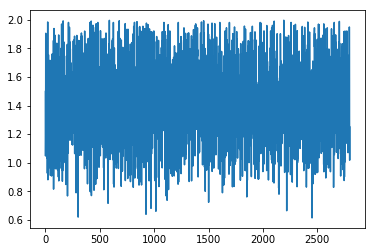

In [54]:
# beta = np.mean(list(fit.extract().values())[0].tolist())
import matplotlib.pyplot as plt
beta = list(fit.extract().values())[0].tolist()
plt.plot(beta)
plt.show()
# problem - for 1k iteration the value of beta does not converge
# for 2k iteration it does not converge neither
# for 3k the same story
# ok, the values do not converge - I do numerous fits for different dataset for the same number of excesses, then I take the average of
# the obtained values

In [ ]:
alpha1 = np.mean(list(fit.extract().values())[1].tolist())
alpha2 = np.mean(list(fit.extract().values())[2].tolist())

In [55]:
len(C[0].tolist())

21

In [56]:
# we prepare array for the values of the beta and alpha1,2 parameters 
number_of_fits = len(C[0].tolist())
betas = np.zeros(number_of_fits)
alphas1 = np.zeros(number_of_fits)
alphas2 = np.zeros(number_of_fits)
# so the method works, now we need to make about 100 fits and to average over the fits, maybe set up better priors
# we should also plot the histogram of data and compare it with density function on one plot

In [57]:
for i in range(0, len(betas)):
    data = dict(N = len(C[i].tolist()),  y3 = C[i].tolist())
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
    betas[i] = np.mean(list(fit.extract().values())[0].tolist())
    alphas1[i] = np.mean(list(fit.extract().values())[1].tolist())
    alphas2[i] = np.mean(list(fit.extract().values())[2].tolist())
# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C

In [67]:
print("Average over dataset of k = 50 excesses from frechet distribution of 1000 variables, we considered 50 excesses.","\n", "mean of alphas1 = ", np.mean(alphas1), "\n", "mean of alphas2 = ", np.mean(alphas2),"\n", "mean of betas = ", np.mean(betas)) 

Average over dataset of k = 50 excesses from frechet distribution of 1000 variables, we considered 50 excesses. 
 mean of alphas1 =  3.2112827937092043 
 mean of alphas2 =  0.4700266543370785 
 mean of betas =  1.7022636673804648


In [ ]:
# I'm not sure whether priors used above are adequate.
# comment about testing not excess values.
# so it recovers good parameters for not big values of df1, df2.

In [ ]:
# here we consider datasets with excesses of different size, lets try k = 100 from burr distribution

In [77]:
from scipy.stats import burr

c, d, N = 1, 0.5, 1000
# burr = burr.rvs(c, d, size=N)
# from scipy.stats import f
r = burr.rvs(c, d, size=N)# we create first column of data sampled from desired distribution and then we add to them others
n = 20 # number of datasets we investigate

for i in range(n):
    r = np.column_stack((r, burr.rvs(c, d, size=N))) # 20 replications of datas from frechet distribution in columns
    
np.min(r)
# np.shape(r)
# print((r[0,:]))

2.8378211577706037e-09

In [78]:
# we need to sort in increasing order gathered data
for i in range(0, len(r[0,:])):# now we have sampled data in columns, we sort each column in increasing order 
    # so that to easily get excesses
    r[:,i] = np.sort(r[:,i], axis=None)# we sort data sampled from frechet, each dataset is in separate column


In [79]:
data_burr,u = k_greatest_values(r,k) # in data frechet we keep the matrix of excesses, each sampled data set is in 


In [80]:
B = [[x]*50 for x in u] # form the array of u values we create matrix, in columns we have repeated u values   
A = np.delete(data_burr, 0, 1)  # delete first column of a matrix A, 
# which is full of zeros and was necessery to get column_stack

In [81]:
C = np.array(A) - np.array(B).transpose() # here we subtract u_i from excesses in each dataset

In [82]:
number_of_fits = len(C[0].tolist())
betas = np.zeros(number_of_fits)
alphas1 = np.zeros(number_of_fits)
alphas2 = np.zeros(number_of_fits)
# so the method works, now we need to make about 100 fits and to average over the fits, maybe set up better priors
# we should also plot the histogram of data and compare it with density function on one plot

In [83]:
for i in range(0, len(betas)):
    data = dict(N = len(C[i].tolist()),  y3 = C[i].tolist())
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
    betas[i] = np.mean(list(fit.extract().values())[0].tolist())
    alphas1[i] = np.mean(list(fit.extract().values())[1].tolist())
    alphas2[i] = np.mean(list(fit.extract().values())[2].tolist())
# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d2d02e51f94a9181eb9337334d024 NOW.
INFO:pystan:COMPILING THE C

In [84]:
print("Average over dataset of k = 50 excesses from burr distribution of 1000 variables, we considered 50 excesses.","\n", "mean of alphas1 = ", np.mean(alphas1), "\n", "mean of alphas2 = ", np.mean(alphas2),"\n", "mean of betas = ", np.mean(betas)) 

Average over dataset of k = 50 excesses from burr distribution of 1000 variables, we considered 50 excesses. 
 mean of alphas1 =  1.9250483082396308 
 mean of alphas2 =  2.295012469352681 
 mean of betas =  1.75062237579999


In [ ]:
# what are plots in publication ? what we need to plot ?

In [85]:
print("aa")

aa


In [ ]:
# saving values of parameters of the fit
beta = np.mean(list(fit.extract().values())[0].tolist())
alpha1 = np.mean(list(fit.extract().values())[1].tolist())
alpha2 = np.mean(list(fit.extract().values())[2].tolist())

In [ ]:
myHist = plt.hist(data_frechet, 100, normed=True)
plt.show()

In [ ]:
import scipy.special as ss
# here we want to get a pdf to plot it on histogram
# function which returns probability density of fisher
def fisher_den(x,alpha1,alpha2,beta1):
    return(1/ss.beta(alpha1,alpha2)*np.exp(-np.log(beta1)+(alpha1-1)*np.log(x/beta1)-(alpha1+alpha2)*np.log(1+x/beta1))) 
x = np.linspace(0,600) 

In [ ]:
plt.plot(fisher_den(x,1,1,1))

In [ ]:
# we investigate closer the values of mcmc chain for each parameters, in particular we should verify if it converges
plt.plot(alpha1[0:100])

In [ ]:
# estimation of quantiles 
def quantile_GPD(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05

def quantile_Fisher(N, F_y):
    return(u + F_y) # F_y is inversed survival function available for programmed .f distribution in python

In [ ]:
# these values are the same as in the programmed form of fisher distribution, to transform them to alpha's, beta we need to do 
# as below, however now we have corrected the form of the distribution so that it is no longer necessery
df1 = np.mean(list(fit.extract().values())[0].tolist())
df2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1, alpha2, beta_f = df1 / 2, df2 / 2, df2 / df1
print(alpha1, alpha2, beta_f)